# A script for creating customised DAG diagrams from Numpyro Models

In [46]:
import sys
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax import random, vmap, jit
import numpyro
from scipy.spatial import distance_matrix
from src.model_fitting_functions import base_model,bg_model,bg_gp_model, top_model,full_model
from src.model_fitting_functions import run_inference

In [23]:
folder_path = '/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/Land_Only_Distributed_Observations_100/'

df_sample = pd.read_csv(f'{folder_path}AP_Daily_Snowfall_044_Sample.csv')
sample_data = df_sample['prsn'].to_numpy()
sample_data = sample_data.reshape(len(df_sample['month'].unique()),len(df_sample['lonlat'].unique()),-1) # ordered [months,sites,days]
sample_data = np.moveaxis(sample_data, -1, 0) # adjusting the axes so that it's [days,months,sites]
jsample_data = jnp.array(sample_data)
df = pd.read_csv(f'{folder_path}AP_BGLima_Snowfall_044_Mean_Alpha_stand.csv', index_col=0)
X = jnp.array(df[['grid_latitude_stand','grid_longitude_stand']].values)
distance_matrix_values = jnp.array(distance_matrix(X,X))

# Site Level Model

In [25]:
site_level_model = numpyro.render_model(base_model, model_args=(jsample_data,), render_distributions=True)
site_level_model.node('p','<p<SUB>i</SUB>>')
site_level_model.node('alpha','<&alpha;<SUB>i</SUB>>')
site_level_model.node('beta','<&beta;<SUB>i</SUB>>')
site_level_model.node('obs','<Y<SUB>i</SUB>>')
site_level_model.node('distribution_description_node','<Y<SUB>i</SUB>~ Bernoulli-Gamma(<B>&Phi;</B><SUB>i</SUB>)>')# ~ BernoulliGamma\l')

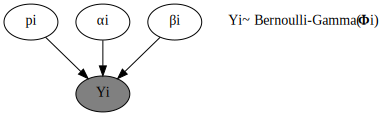

In [27]:
site_level_model

In [37]:
# Saving Diagram as PNG
site_level_model.render(format='png',filename='Base_Model')

'Model_DAGs/Base_Model.png'

# Spatial Model

In [38]:
spatial_model = numpyro.render_model(top_model, model_args=(distance_matrix_values,jsample_data,), render_distributions=True)#,filename='Base_Model.png')
spatial_model.node('alpha','<&alpha;>')
spatial_model.node('kernel_var_alpha','<&sigma;>')
spatial_model.node('kernel_noise_alpha','n')
spatial_model.node('kernel_length_alpha','l')
spatial_model.node('distribution_description_node','<&alpha;~GP(0,<B>&Theta;</B>)>')

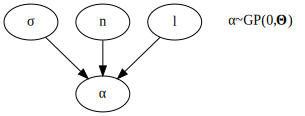

In [39]:
spatial_model

In [41]:
# Saving Diagram as PNG
spatial_model.render(format='png',filename='Spatial_Model')

'Model_DAGs/Spatial_Model.png'

# Hierarchical Simple Model

In [47]:
hierarchical_model = numpyro.render_model(full_model, model_args=(distance_matrix_values,jsample_data,), render_distributions=True)#,filename='Base_Model.png')
hierarchical_model.node('obs','<<B>Y</B>>')
hierarchical_model.node('alpha','<<B>&alpha;</B>>')
hierarchical_model.node('kernel_var_alpha','<&sigma;<SUB>&alpha;</SUB>>')
hierarchical_model.node('kernel_noise_alpha','<n<SUB>&alpha;</SUB>>')
hierarchical_model.node('kernel_length_alpha','<l<SUB>&alpha;</SUB>>')

hierarchical_model.node('beta','<<B>&beta;</B>>')
hierarchical_model.node('kernel_var_beta','<&sigma;<SUB>&beta;</SUB>>')
hierarchical_model.node('kernel_noise_beta','<n<SUB>&beta;</SUB>>')
hierarchical_model.node('kernel_length_beta','<l<SUB>&beta;</SUB>>')

hierarchical_model.node('p','<<B>p</B>>')
hierarchical_model.node('kernel_var_p','<&sigma;<SUB>p</SUB>>')
hierarchical_model.node('kernel_noise_p','<n<SUB>p</SUB>>')
hierarchical_model.node('kernel_length_p','<l<SUB>p</SUB>>')

hierarchical_model.node('distribution_description_node','<Y<SUB>i</SUB>~ Bernoulli-Gamma(<B>&Phi;</B><SUB>i</SUB>)<BR/><BR/><B>&alpha;</B>~MVN(0,<B>&Theta;</B><SUB>&alpha;</SUB>)<BR/><BR/><B>&beta;</B>~MVN(0,<B>&Theta;</B><SUB>&beta;</SUB>)<BR/><BR/><B>p</B>~MVN(0,<B>&Theta;</B><SUB>p</SUB>)>')

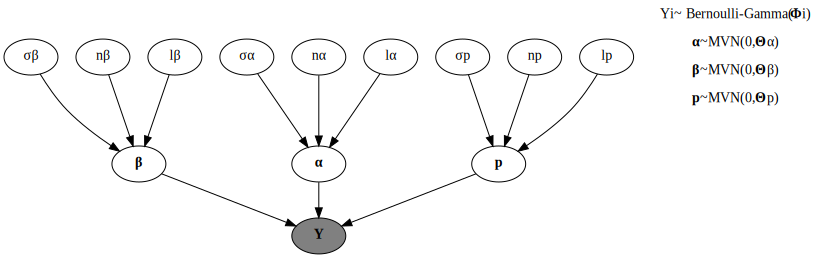

In [48]:
hierarchical_model

In [49]:
# Saving Diagram as PNG
hierarchical_model.render(format='png',filename='Hierarchical_Model')

'Model_DAGs/Hierarchical_Model.png'

# Full Model

In [50]:
full_model = numpyro.render_model(bg_gp_model, model_args=(distance_matrix_values,jsample_data,), render_distributions=True)#,filename='Base_Model.png')
full_model.node('obs','<<B>Y</B>>')
full_model.node('log_alpha','<log(<B>&alpha;</B>)>')
full_model.node('kernel_var_alpha','<&sigma;<SUB>&alpha;</SUB>>')
full_model.node('kernel_noise_alpha','<n<SUB>&alpha;</SUB>>')
full_model.node('kernel_length_alpha','<l<SUB>&alpha;</SUB>>')

full_model.node('beta','<<B>&beta;</B>>')
full_model.node('a0','<a<SUB>0</SUB>>')
full_model.node('a1','<a<SUB>1</SUB>>')
full_model.node('betavar','<&sigma;<SUB>&beta;</SUB>>')

full_model.node('logit_p','<logit(<B>p</B>)>')
full_model.node('kernel_var_p','<&sigma;<SUB>p</SUB>>')
full_model.node('kernel_noise_p','<n<SUB>p</SUB>>')
full_model.node('kernel_length_p','<l<SUB>p</SUB>>')

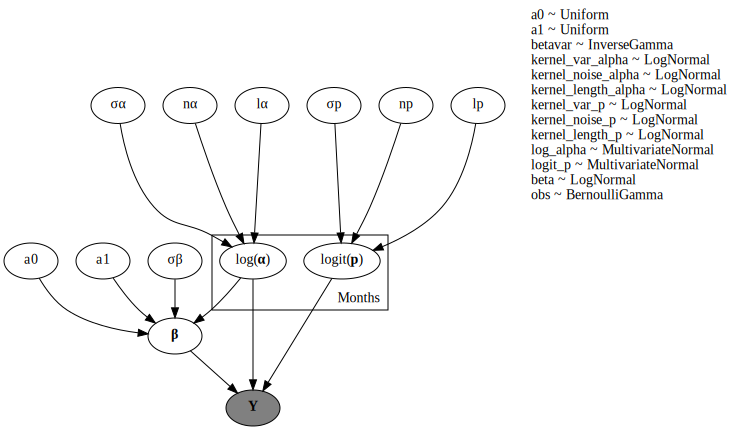

In [51]:
full_model

In [52]:
# Saving Diagram as PNG
full_model.render(format='png',filename='Full_Model')

'Model_DAGs/Full_Model.png'